# 1. IMPORTS

In [2]:
import os,pandas,sys,time,keras,json,sklearn,tensorflow,random
import numpy as np
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['PYTHONHASHSEED']='0'

def reseed():
    seed = 0x5f3759df
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
    random.seed(seed)

from starter import Starter
starter = Starter()
starter.start(lambda: os.chdir(os.path.dirname(os.getcwd())))

2025-05-30 15:18:33.480043: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:18:35.395164: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 15:18:36.960991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748593118.403781   69343 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748593118.766518   69343 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748593122.705707   69343 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Starter has been initialized.


# 2. LOAD DATA

In [3]:
#!/usr/bin/env python3
from utils.data_loader import DataLoader
import numpy as np 

print("1. LOADING AND PREPROCESSING DATA")
print("="*50)

# Initialize data loader
data_dir = "../data" 
data_loader = DataLoader(data_dir)

# Load and prepare data
try:
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_loader.prepare_data(
        max_vocab_size=5000,
        max_length=50,
    )
    
    print("\nData loaded successfully!")
    print(f"Vocabulary size: {data_loader.preprocessor.vocab_size}")
    print(f"Number of classes: {data_loader.num_classes}")
    print(f"Max sequence length: {data_loader.preprocessor.max_length}")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = data_loader.reverse_label_encoder[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
    print("\nData shapes:")
    print(f"  Training: X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={X_valid.shape}, y={y_valid.shape}")
    print(f"  Test: X={X_test.shape}, y={y_test.shape}")
    
    # Display sample data
    print("\nSample data:")
    print(f"  First training text tokens: {X_train[0][:10]}...")
    print(f"  First training label: {y_train[0]} ({data_loader.reverse_label_encoder[y_train[0]]})")
    
    # Verify data integrity
    print("\nData integrity checks:")
    print(f"  No missing values in X_train: {not np.any(np.isnan(X_train))}")
    print(f"  No missing values in y_train: {not np.any(np.isnan(y_train))}")
    print(f"  All labels in valid range: {np.all((y_train >= 0) & (y_train < data_loader.num_classes))}")
    
    print("\nData preprocessing completed successfully!")
        
except Exception as e:
    print(f"Error loading data: {e}")
    import traceback
    traceback.print_exc()
    raise e


1. LOADING AND PREPROCESSING DATA
Loaded data:
  Train: 500 samples
  Valid: 100 samples
  Test: 400 samples


2025-05-30 15:19:17.679678: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Keras vectorizer vocabulary size: 2836
Sample vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]

Data shapes:
  X_train: (500, 50)
  y_train: (500,)
  X_valid: (100, 50)
  y_valid: (100,)
  X_test: (400, 50)
  y_test: (400,)

Data loaded successfully!
Vocabulary size: 2836
Number of classes: 3
Max sequence length: 50

Class distribution in training data:
  negative: 192 (38.4%)
  neutral: 119 (23.8%)
  positive: 189 (37.8%)

Data shapes:
  Training: X=(500, 50), y=(500,)
  Validation: X=(100, 50), y=(100,)
  Test: X=(400, 50), y=(400,)

Sample data:
  First training text tokens: [1758 1080 1145  196 2834  198   11  607  177  847]...
  First training label: 1 (neutral)

Data integrity checks:
  No missing values in X_train: True
  No missing values in y_train: True
  All labels in valid range: True

Data preprocessing completed successfully!


# 3. INITIALIZE EXPERIMENT RUNNER

In [4]:
#!/usr/bin/env python3
import os
import time
import json
import numpy as np
import keras
import sklearn.metrics


class KerasLSTMExperiment:
    """Keras LSTM experiment class for systematic hyperparameter analysis"""
    
    def __init__(self, data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.data_loader = data_loader
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
        # Base configuration
        self.base_config = {
            'vocab_size': data_loader.preprocessor.vocab_size,
            'embedding_dim': 64,
            'lstm_units': 32,
            'num_classes': data_loader.num_classes,
            'max_length': data_loader.preprocessor.max_length,
            'activation': 'tanh',
            'dropout_rate': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 15
        }
        
        print(f"Base configuration:")
        for key, value in self.base_config.items():
            print(f"  {key}: {value}")
    
    def create_keras_model(self, config):
        """Create Keras lstm model with given configuration"""
        reseed()
        model = keras.models.Sequential()
        model.add(keras.layers.Embedding(
            input_dim=config['vocab_size'],
            output_dim=config['embedding_dim'],
            input_length=config['max_length'],
            name='embedding'
        ))
        
        for i in range(config['num_lstm_layers']):
            return_sequences = i < config['num_lstm_layers'] - 1
            lstm_layer = keras.layers.LSTM(
                units=config['lstm_units'],
                activation=config['activation'],
                return_sequences=return_sequences,
                name=f'lstm_{i}'
            )
            
            if config['bidirectional']:
                model.add(keras.layers.Bidirectional(lstm_layer, name=f'bidirectional_lstm_{i}'))
            else:
                model.add(lstm_layer)
            
            if i < config['num_lstm_layers'] - 1:
                model.add(keras.layers.Dropout(config['dropout_rate'], name=f'dropout_{i}'))
        
        model.add(keras.layers.Dropout(config['dropout_rate'], name='dropout_final'))
        model.add(keras.layers.Dense(config['num_classes'], activation='softmax', name='classification'))
        
        model.build(input_shape=(None, config['max_length']))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate(self, config, experiment_name):
        print(f"\n{'='*60}")
        print(f"Training: {experiment_name}")
        print(f"Config: {config}")
        print(f"{'='*60}")
        
        start_time = time.time()
        model = self.create_keras_model(config)
        print(f"Model created with {model.count_params():,} parameters")
        
        print(f"Starting training for {config['epochs']} epochs...")
        history = model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_valid, self.y_valid),
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=1,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
            ],
            shuffle=False
        )
        
        print(f"Evaluating on test set...")
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=0)
        test_predictions = model.predict(self.X_test, verbose=0)
        test_pred_classes = np.argmax(test_predictions, axis=1)
        test_f1_macro = sklearn.metrics.f1_score(self.y_test, test_pred_classes, average='macro')
        
        valid_predictions = model.predict(self.X_valid, verbose=0)
        valid_pred_classes = np.argmax(valid_predictions, axis=1)
        valid_f1_macro = sklearn.metrics.f1_score(self.y_valid, valid_pred_classes, average='macro')
        
        weights_path = f"results/{experiment_name}_weights.npz"
        os.makedirs("results", exist_ok=True)
        self.save_keras_weights(model, weights_path, config)

        unique_rows = np.unique(self.X_test, axis=0)

        
        training_time = time.time() - start_time
        
        print(f"\nResults for {experiment_name}:")
        print(f"  Training time: {training_time:.2f} seconds")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Test F1-Score (macro): {test_f1_macro:.4f}")
        print(f"  Valid F1-Score (macro): {valid_f1_macro:.4f}")
        print(f"  Weights saved to: {weights_path}")
        
        return {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_f1_score': test_f1_macro,
            'valid_f1_score': valid_f1_macro,
            'weights_path': weights_path,
            'config': config,
            'training_time': training_time
        }
    
    def save_keras_weights(self, model, filepath, config):
        print(f"Saving Keras weights to: {filepath}")
        
        try:
            if len(model.weights) == 0:
                raise ValueError("Model has no weights to save!")
            
            weights_dict = {}
            lstm_layer_count = 0
            
            for layer in model.layers:
                layer_weights = layer.get_weights()
                if len(layer_weights) == 0:
                    continue
                    
                layer_name = layer.name
                print(f"  Processing layer: {layer_name} - {len(layer_weights)} weight arrays")
                
                if 'embedding' in layer_name.lower():
                    weights_dict['embedding'] = {
                        'embedding_matrix': layer_weights[0]
                    }
                elif 'simple_lstm' in layer_name.lower():
                    target_name = f'lstm_{lstm_layer_count}'
                    weights_dict[target_name] = {
                        'W_ih': layer_weights[0].T,
                        'W_hh': layer_weights[1].T,
                        'b_h': layer_weights[2]
                    }
                    lstm_layer_count += 1
                elif 'bidirectional' in layer_name.lower():
                    target_name = f'bidirectional_lstm_{lstm_layer_count}'
                    if len(layer_weights) >= 6:
                        weights_dict[target_name] = {
                            'forward_W_ih': layer_weights[0].T,
                            'forward_W_hh': layer_weights[1].T,
                            'forward_b_h': layer_weights[2],
                            'backward_W_ih': layer_weights[3].T,
                            'backward_W_hh': layer_weights[4].T,
                            'backward_b_h': layer_weights[5]
                        }
                    lstm_layer_count += 1
                elif 'dense' in layer_name.lower() or 'classification' in layer_name.lower():
                    weights_dict['classification'] = {
                        'W': layer_weights[0].T,
                        'b': layer_weights[1]
                    }
            
            save_dict = {}
            for layer_name, layer_weights in weights_dict.items():
                for weight_name, weight_value in layer_weights.items():
                    save_dict[f"{layer_name}_{weight_name}"] = weight_value
            
            save_dict['config'] = json.dumps(config)
            np.savez(filepath, **save_dict)
            print(f"  Saved {len(save_dict)-1} weight arrays successfully")
            print(f"  Layers saved: {list(weights_dict.keys())}")
            
            loaded_check = np.load(filepath)
            assert len(loaded_check.files) == len(save_dict), "Save verification failed"
            loaded_check.close()
        
        except Exception as e:
            print(f"Error saving weights: {e}")
            import traceback
            traceback.print_exc()
            raise


print("Initializing Keras experiment framework...")
keras_experiment = KerasLSTMExperiment(
    data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test
)
print("Keras experiment runner initialized!")


Initializing Keras experiment framework...
Base configuration:
  vocab_size: 2836
  embedding_dim: 64
  lstm_units: 32
  num_classes: 3
  max_length: 50
  activation: tanh
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 32
  epochs: 15
Keras experiment runner initialized!


# 4. EXPERIMENTS

## 4.1. Comparing Layer Counts

In [5]:
#!/usr/bin/env python3
layer_counts = [1, 3, 5]
layer_results = {}

for num_layers in layer_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_lstm_layers': num_layers,
        'bidirectional': True, 
        'lstm_units': 64
    })
    # config['epochs'] = 10
    
    experiment_name = f"lstm_layers_{num_layers}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layers: {num_layers}, Units: {config['lstm_units']}, Bidirectional: {config['bidirectional']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        for k,v in result.items():
            print(k, v)
        layer_results[num_layers] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(layer_results.keys()):
    result = layer_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")



🔬 Experiment: lstm_layers_1
   Layers: 1, Units: 64, Bidirectional: True

Training: lstm_layers_1
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'lstm_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_lstm_layers': 1, 'bidirectional': True}


/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model created with 247,939 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3829 - loss: 1.0917 - val_accuracy: 0.4500 - val_loss: 1.0573
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4845 - loss: 1.0033 - val_accuracy: 0.5600 - val_loss: 0.9533
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6284 - loss: 0.8287 - val_accuracy: 0.5700 - val_loss: 0.9066
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7455 - loss: 0.6815 - val_accuracy: 0.6400 - val_loss: 0.8058
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8597 - loss: 0.4432 - val_accuracy: 0.7300 - val_loss: 0.7314
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9538 - loss: 0.2178 - val_accuracy: 0.7700 - val_loss: 0.7170
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9786 - loss: 0.1163 - val_accuracy: 0.7800 - val_loss: 0.7230
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model created with 445,571 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.3816 - loss: 1.0829 - val_accuracy: 0.5000 - val_loss: 0.9816
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5131 - loss: 0.9160 - val_accuracy: 0.5500 - val_loss: 0.9398
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6603 - loss: 0.7609 - val_accuracy: 0.6300 - val_loss: 0.7654
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8733 - loss: 0.3743 - val_accuracy: 0.7000 - val_loss: 0.8031
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9559 - loss: 0.1500 - val_accuracy: 0.7300 - val_loss: 0.9408
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9858 - loss: 0.0511 - val_accuracy: 0.7200 - val_loss: 1.1311
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9906 - loss: 0.0264 - val_accuracy: 0.7100 - val_loss: 1.2570
Epoch 8/15
16/16 ━━━━━━━━━━━━━━

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model created with 643,203 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.4152 - loss: 1.0687 - val_accuracy: 0.5400 - val_loss: 0.9583
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.5846 - loss: 0.8958 - val_accuracy: 0.6100 - val_loss: 0.8281
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.7033 - loss: 0.6225 - val_accuracy: 0.5900 - val_loss: 0.9106
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8173 - loss: 0.4040 - val_accuracy: 0.5600 - val_loss: 1.1695
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9042 - loss: 0.2885 - val_accuracy: 0.6200 - val_loss: 1.1136
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9636 - loss: 0.1469 - val_accuracy: 0.5800 - val_loss: 1.4190
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9396 - loss: 0.1841 - val_accuracy: 0.6500 - val_loss: 1.1790
Evaluating on test set...
Savi

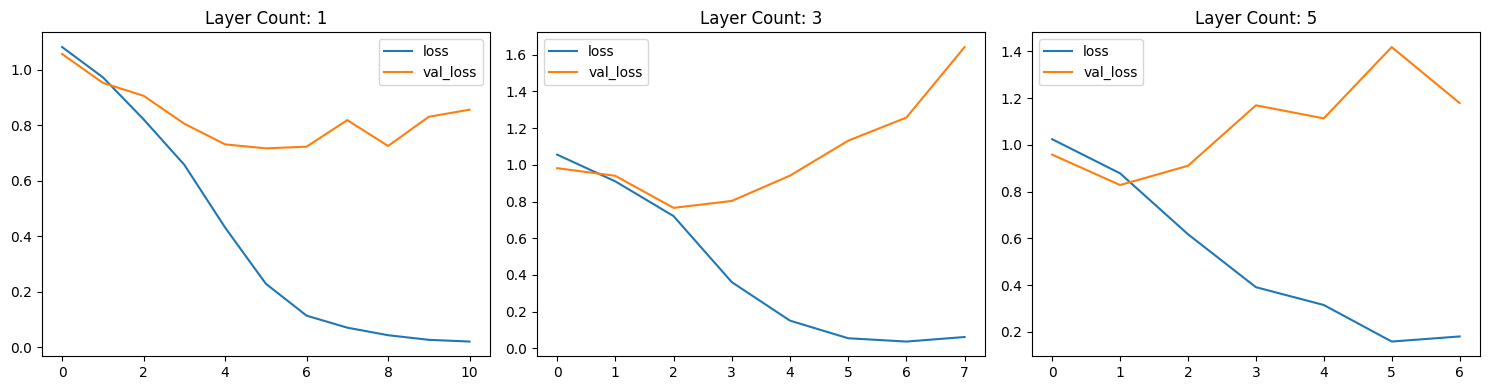

In [6]:
import math

columns = 3
total_plots = len(layer_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (layer_count, L) in enumerate(sorted(layer_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f'Layer Count: {layer_count}')
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 4.2. Comparing Cell/Unit Counts

In [7]:
#!/usr/bin/env python3
cell_counts = [16, 64, 128, 256]
cell_results = {}

for num_cells in cell_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_lstm_layers': 1,
        'bidirectional': True, 
        'lstm_units': num_cells
    })
    experiment_name = f"lstm_cells_{num_cells}"
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        cell_results[num_cells] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'Cells':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for cells in sorted(cell_results.keys()):
    result = cell_results[cells]
    print(f"{cells:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")



Training: lstm_cells_16
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'lstm_units': 16, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_lstm_layers': 1, 'bidirectional': True}
Model created with 191,971 parameters
Starting training for 15 epochs...
Epoch 1/15


/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3590 - loss: 1.0929 - val_accuracy: 0.3700 - val_loss: 1.0684
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4394 - loss: 1.0429 - val_accuracy: 0.4700 - val_loss: 1.0178
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5766 - loss: 0.9317 - val_accuracy: 0.6000 - val_loss: 0.9229
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7375 - loss: 0.7888 - val_accuracy: 0.6000 - val_loss: 0.8650
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8141 - loss: 0.6670 - val_accuracy: 0.6600 - val_loss: 0.8151
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8600 - loss: 0.5453 - val_accuracy: 0.7300 - val_loss: 0.7491
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9333 - loss: 0.3788 - val_accuracy: 0.7100 - val_loss: 0.7066
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9689 - loss: 0.2199 - val_accuracy: 0.6900 - val_loss: 0.

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3829 - loss: 1.0917 - val_accuracy: 0.4500 - val_loss: 1.0573
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4845 - loss: 1.0033 - val_accuracy: 0.5600 - val_loss: 0.9533
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6284 - loss: 0.8287 - val_accuracy: 0.5700 - val_loss: 0.9066
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7455 - loss: 0.6815 - val_accuracy: 0.6400 - val_loss: 0.8058
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8597 - loss: 0.4432 - val_accuracy: 0.7300 - val_loss: 0.7314
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9538 - loss: 0.2178 - val_accuracy: 0.7700 - val_loss: 0.7170
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9786 - loss: 0.1163 - val_accuracy: 0.7800 - val_loss: 0.7230
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9959 - loss: 0.0626 - val_accuracy: 0.7300 - val_loss: 0.

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4055 - loss: 1.0844 - val_accuracy: 0.4700 - val_loss: 1.0049
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.4913 - loss: 0.9518 - val_accuracy: 0.5800 - val_loss: 0.9326
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6311 - loss: 0.8045 - val_accuracy: 0.6100 - val_loss: 0.8714
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7628 - loss: 0.6303 - val_accuracy: 0.6400 - val_loss: 0.7726
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8338 - loss: 0.4198 - val_accuracy: 0.6800 - val_loss: 0.8050
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9288 - loss: 0.2669 - val_accuracy: 0.6900 - val_loss: 0.7782
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9771 - loss: 0.1622 - val_accuracy: 0.7400 - val_loss: 0.7269
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9856 - loss: 0.0702 - val_accuracy: 0.7400 - val_loss: 

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.4273 - loss: 1.0781 - val_accuracy: 0.5600 - val_loss: 1.0102
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.5746 - loss: 0.9466 - val_accuracy: 0.4000 - val_loss: 0.9833
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.6294 - loss: 0.8190 - val_accuracy: 0.6000 - val_loss: 0.8139
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.8022 - loss: 0.6044 - val_accuracy: 0.6100 - val_loss: 0.8113
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.8958 - loss: 0.4606 - val_accuracy: 0.6400 - val_loss: 0.8401
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.9353 - loss: 0.2772 - val_accuracy: 0.6300 - val_loss: 0.9451
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.9506 - loss: 0.2262 - val_accuracy: 0.6800 - val_loss: 1.0226
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.9719 - loss: 0.1237 - val_accuracy: 0.6700 - val_

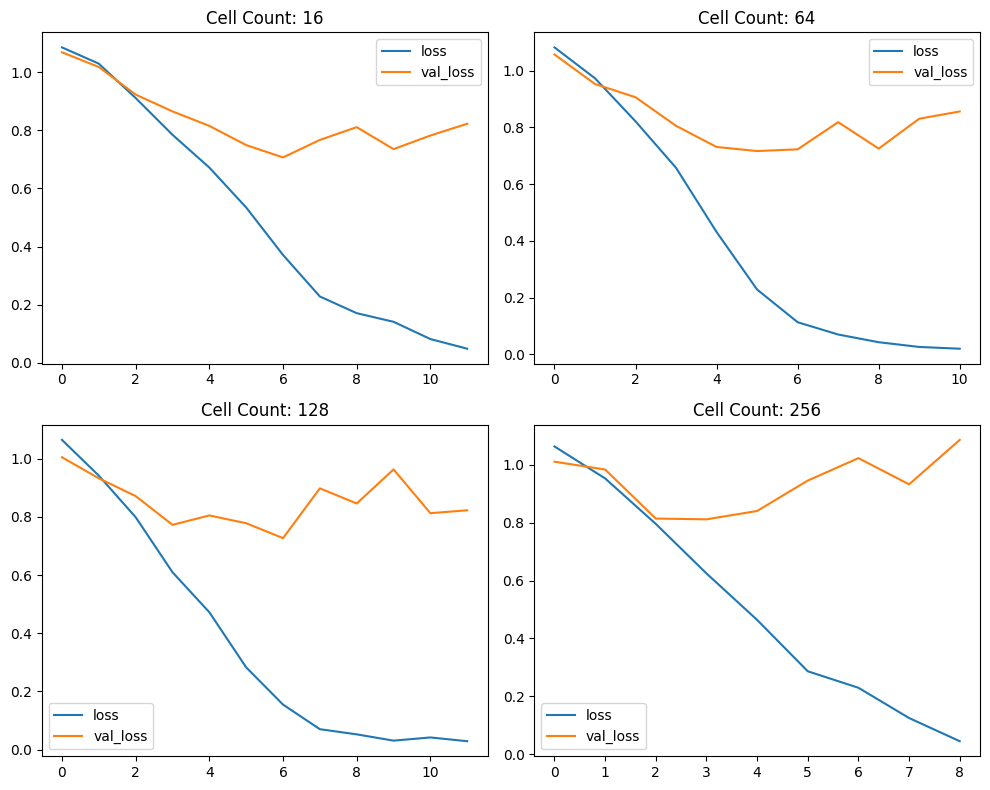

In [8]:
import math

columns = 2
total_plots = len(cell_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (cell_count, L) in enumerate(sorted(cell_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f'Cell Count: {cell_count}')
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 4.3. Comparing Bidirectional vs. Unidirectional Layers

In [9]:
#!/usr/bin/env python3
ltype_results = {}
ltype_vars = [False, True]

for ltype in ltype_vars:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_lstm_layers': 1,
        'bidirectional': ltype, 
        'lstm_units': 64
    })
    experiment_name = f"lstm_ltypes_{'bidirectional' if ltype else 'not unidirectional'}"
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        ltype_results[ltype] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'ltypes':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for ltypes in sorted(ltype_results.keys()):
    result = ltype_results[ltypes]
    print(f"{ltypes:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")



Training: lstm_ltypes_not unidirectional
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'lstm_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_lstm_layers': 1, 'bidirectional': False}
Model created with 214,723 parameters
Starting training for 15 epochs...
Epoch 1/15


/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3686 - loss: 1.0971 - val_accuracy: 0.3700 - val_loss: 1.0841
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3950 - loss: 1.0878 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4254 - loss: 1.0737 - val_accuracy: 0.5100 - val_loss: 1.0066
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4726 - loss: 0.9811 - val_accuracy: 0.5200 - val_loss: 0.9588
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5746 - loss: 0.8601 - val_accuracy: 0.6000 - val_loss: 0.8726
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6684 - loss: 0.6973 - val_accuracy: 0.6000 - val_loss: 0.9774
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7064 - loss: 0.5931 - val_accuracy: 0.6000 - val_loss: 0.8928
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7307 - loss: 0.5432 - val_accuracy: 0.4500 - val_loss: 1.

/mnt/d/GitHub/tugas-besar-ml-2/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3829 - loss: 1.0917 - val_accuracy: 0.4500 - val_loss: 1.0573
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4845 - loss: 1.0033 - val_accuracy: 0.5600 - val_loss: 0.9533
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6284 - loss: 0.8287 - val_accuracy: 0.5700 - val_loss: 0.9066
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7455 - loss: 0.6815 - val_accuracy: 0.6400 - val_loss: 0.8058
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8597 - loss: 0.4432 - val_accuracy: 0.7300 - val_loss: 0.7314
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9538 - loss: 0.2178 - val_accuracy: 0.7700 - val_loss: 0.7170
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9786 - loss: 0.1163 - val_accuracy: 0.7800 - val_loss: 0.7230
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9959 - loss: 0.0626 - val_accuracy: 0.7300 - val_loss: 0.

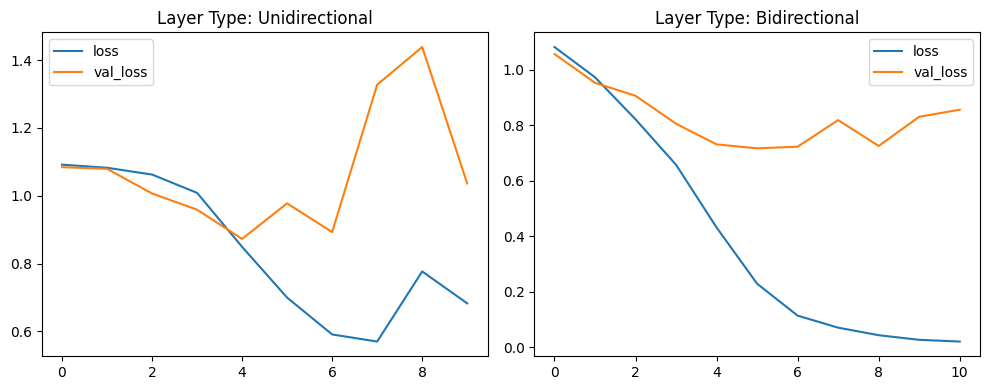

In [10]:
import math

columns = 2
total_plots = len(ltype_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (ltype_var, L) in enumerate(sorted(ltype_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f'Layer Type: {'Bidirectional' if ltype_var else 'Unidirectional'}')
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. COMPARE WITH FROM SCRATCH

In [ ]:
#!/usr/bin/env python3
from models import lstm

def compare_keras_vs_scratch(keras_result, experiment_name):
    """Compare Keras model with from-scratch implementation - Formal Version"""
    print(f"\nExperiment: {experiment_name.replace('_', ' ').title()}")
    print("-" * 50)

    try:
        keras_model = keras_result['model']
        config = keras_result['config']
        weights_path = keras_result['weights_path']

        print(f"Comparing experiment: {experiment_name}")
        print(f"Using configuration: {config}")
        print(f"Loading weights from: {weights_path}")

        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")

        scratch_model = lstm.LSTMModelBuilder.create_lstm_model(
            vocab_size=config['vocab_size'],
            embedding_dim=config['embedding_dim'],
            lstm_units=config['lstm_units'],
            num_classes=config['num_classes'],
            num_lstm_layers=config['num_lstm_layers'],
            bidirectional=True, # biar bagus
            dropout_rate=config['dropout_rate'],
            # activation=config['activation']
        )

        print("From-scratch model summary:")
        print(scratch_model.summary())

        sample_input = X_test[:5]
        _ = scratch_model.forward(sample_input)
        print(f"Model built successfully with input shape: {sample_input.shape}")

        scratch_model.load_weights(weights_path)
        scratch_model.set_training(False)

        print(f"Comparing predictions on {len(X_test)} test samples...")

        keras_predictions = keras_model.predict(X_test, verbose=0)
        scratch_predictions = scratch_model.predict(X_test)

        print(f"Keras predictions shape: {keras_predictions.shape}")
        print(f"Scratch predictions shape: {scratch_predictions.shape}")

        if keras_predictions.shape != scratch_predictions.shape:
            raise ValueError(f"Shape mismatch: Keras {keras_predictions.shape} vs Scratch {scratch_predictions.shape}")

        keras_pred_classes = np.argmax(keras_predictions, axis=1)
        scratch_pred_classes = np.argmax(scratch_predictions, axis=1)

        keras_accuracy = np.mean(keras_pred_classes == y_test)
        scratch_accuracy = np.mean(scratch_pred_classes == y_test)

        keras_f1 = sklearn.metrics.f1_score(y_test, keras_pred_classes, average='macro')
        scratch_f1 = sklearn.metrics.f1_score(y_test, scratch_pred_classes, average='macro')

        max_diff = np.max(np.abs(keras_predictions - scratch_predictions))
        mean_diff = np.mean(np.abs(keras_predictions - scratch_predictions))
        similarity = np.mean(np.isclose(keras_predictions, scratch_predictions, atol=1e-5))

        print("\nComparison Results")
        print(f"{'Metric':<25} {'Keras':<12} {'From-Scratch':<12} {'Difference':<12}")
        print("-" * 63)
        print(f"{'Accuracy':<25} {keras_accuracy:<12.6f} {scratch_accuracy:<12.6f} {abs(keras_accuracy - scratch_accuracy):<12.6f}")
        print(f"{'F1-Score (macro)':<25} {keras_f1:<12.6f} {scratch_f1:<12.6f} {abs(keras_f1 - scratch_f1):<12.6f}")
        print(f"{'Max Prediction Diff':<25} {max_diff:<12.8f}")
        print(f"{'Mean Prediction Diff':<25} {mean_diff:<12.8f}")
        print(f"{'Prediction Similarity':<25} {similarity:<12.6f}")

        print("\nSample Predictions")
        for i in range(min(5, len(X_test))):
            print(f"Sample {i+1}:")
            print(f"  Keras:        {keras_predictions[i]}")
            print(f"  From-scratch: {scratch_predictions[i]}")
            print(f"  Difference:   {np.abs(keras_predictions[i] - scratch_predictions[i])}")
            print(f"  True label:   {y_test[i]} ({data_loader.reverse_label_encoder[y_test[i]]})")
            print(f"  Keras pred:   {keras_pred_classes[i]} ({data_loader.reverse_label_encoder[keras_pred_classes[i]]})")
            print(f"  Scratch pred: {scratch_pred_classes[i]} ({data_loader.reverse_label_encoder[scratch_pred_classes[i]]})")
            print()

        agreement_rate = np.mean(keras_pred_classes == scratch_pred_classes)
        f1_diff = abs(keras_f1 - scratch_f1)
        acc_diff = abs(keras_accuracy - scratch_accuracy)

        print("Additional Validation")
        print(f"Prediction agreement rate: {agreement_rate:.4f}")
        print(f"F1-score difference: {f1_diff:.6f}")
        print(f"Accuracy difference: {acc_diff:.6f}")

        return {
            'keras_accuracy': keras_accuracy,
            'scratch_accuracy': scratch_accuracy,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'max_difference': max_diff,
            'mean_difference': mean_diff,
            'prediction_similarity': similarity,
            'agreement_rate': agreement_rate,
            'experiment_name': experiment_name
        }

    except Exception as e:
        print(f"Error occurred during comparison for {experiment_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'keras_accuracy': 0.0,
            'scratch_accuracy': 0.0,
            'keras_f1': 0.0,
            'scratch_f1': 0.0,
            'max_difference': 999.0,
            'mean_difference': 999.0,
            'prediction_similarity': 0.0,
            'agreement_rate': 0.0,
            'experiment_name': experiment_name,
            'error': str(e)
        }

# Execution block

print("Comparing Keras vs From-Scratch Implementations Using Trained Models")

comparison_results = {}

if layer_results:
    best_layer_count_res = max(layer_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['layers'] = compare_keras_vs_scratch(best_layer_count_res, "layer counts")

if cell_results:
    best_cell_count_res = max(cell_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['units'] = compare_keras_vs_scratch(best_cell_count_res, "unit counts")

if ltype_results:
    best_direction_type_res = max(ltype_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['direction'] = compare_keras_vs_scratch(best_direction_type_res, "direction types")

print("\nSummary of Implementation Comparison")
print("=" * 60)
print(f"{'Experiment':<20} {'Max Diff':<12} {'F1 Diff':<10} {'Agreement':<10} {'Status':<15}")
print("-" * 75)

for category, result in comparison_results.items():
    if 'error' not in result:
        f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
        print(f"{category:<20} {result['max_difference']:<12.6f} {f1_diff:<10.6f} {result['agreement_rate']:<10.4f} Valid")
    else:
        print(f"{category:<20} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} Failed")


Comparing Keras vs From-Scratch Implementations Using Trained Models

Experiment: Layer Counts
--------------------------------------------------
Comparing experiment: layer counts
Using configuration: {'vocab_size': 2836, 'embedding_dim': 64, 'lstm_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_lstm_layers': 1, 'bidirectional': True}
Loading weights from: results/lstm_layers_1_weights.npz
Error occurred during comparison for layer counts: LSTMModelBuilder.create_lstm_model() got an unexpected keyword argument 'activation'

Experiment: Unit Counts
--------------------------------------------------
Comparing experiment: unit counts
Using configuration: {'vocab_size': 2836, 'embedding_dim': 64, 'lstm_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_lstm_layers': 1, 'bidirectional': T

Traceback (most recent call last):
  File "/tmp/ipykernel_69343/3066513842.py", line 21, in compare_keras_vs_scratch
    scratch_model = lstm.LSTMModelBuilder.create_lstm_model(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: LSTMModelBuilder.create_lstm_model() got an unexpected keyword argument 'activation'
Traceback (most recent call last):
  File "/tmp/ipykernel_69343/3066513842.py", line 21, in compare_keras_vs_scratch
    scratch_model = lstm.LSTMModelBuilder.create_lstm_model(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: LSTMModelBuilder.create_lstm_model() got an unexpected keyword argument 'activation'
Traceback (most recent call last):
  File "/tmp/ipykernel_69343/3066513842.py", line 21, in compare_keras_vs_scratch
    scratch_model = lstm.LSTMModelBuilder.create_lstm_model(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: LSTMModelBuilder.create_lstm_model() got an unexpected keyword argument 'activat